#### Setup

In [1]:
import numpy as np
import pandas as pd
from numba import jit
import random
import matplotlib.pyplot as plt
from pprint import pprint
from IPython.display import display
from tabulate import tabulate
import warnings
import torch
import random
import torch.nn as nn
import torch.optim as optim
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10,8) 
plt.style.use('ggplot')

In [2]:
def gametype_to_ran(gametype = '1236'):
    # convert game type into upper bounds for token values
    R1 = 3 ** int(gametype[0]) - 1
    R2 = 3 ** int(gametype[1]) - 1
    R3 = 3 ** int(gametype[2]) - 1
    R4 = 3 ** int(gametype[3]) - 1
    return R1, R2, R3, R4

def token_init(ntokens, nbuyers, nsellers, R1, R2, R3, R4):
    # generate values
    A = np.random.uniform(0, R1)  # common to all
    B = np.random.uniform(0, R2, (2, ))  # buyer/seller differentiator
    C = np.random.uniform(0, R3, (2, ntokens)) # buyer/seller and token differentiator
    D = np.random.uniform(0, R4, (nbuyers+nsellers, ntokens)) # unique token and trader values
    E = D + A
    
    # buyer valuations
    redemption_values = E[0:nbuyers, 0:ntokens]+C[0,:]+B[0]
    sorted_indices = np.argsort(redemption_values, axis=1)[:, ::-1]
    redemption_values = np.take_along_axis(redemption_values, sorted_indices, axis=1)

    # seller costs
    token_costs = E[nbuyers:(nbuyers+nsellers), 0:ntokens]+C[1,:]+B[1]
    sorted_indices_costs = np.argsort(token_costs, axis=1)
    token_costs = np.take_along_axis(token_costs, sorted_indices_costs, axis=1)
    return np.round(redemption_values, 1), np.round(token_costs, 1)

In [3]:
def compute_demand_supply(redemption_values,token_costs,nbuyers,ntokens,granularity=100):
    max_price = np.max(redemption_values)
    min_price = np.min(token_costs)
    P_grid = np.linspace(min_price,max_price,granularity)
    demand_schedule = np.zeros((granularity),dtype = 'int')
    supply_schedule = np.zeros((granularity), dtype = 'int')
    for i, p in enumerate(P_grid):
        demand_schedule[i] = np.sum(p<=redemption_values)  
        supply_schedule[i] = np.sum(p>=token_costs) 
    return demand_schedule, supply_schedule, P_grid, min_price, max_price

def equilibrium(demand_schedule,supply_schedule,P_grid):
    p_eqbm, q_eqbm = [], np.nan
    for i, p in enumerate(P_grid):
        if demand_schedule[i] == supply_schedule[i]: # when sellers are ready to sell
            p_eqbm.append(p)
            q_eqbm = demand_schedule[i] 
    return np.nanmean(p_eqbm), q_eqbm

In [4]:
def graph(demand_schedule, supply_schedule, P_grid, p_eqbm, q_eqbm, 
                        period_bids, period_asks, period_prices, period_sales, 
                        redemption_values, token_costs, ntokens, nbuyers, nsellers, nsteps):
    plt.plot(demand_schedule, P_grid, label = 'Demand Curve')
    plt.plot(supply_schedule, P_grid, label = 'Supply Curve')
    plt.plot(period_prices, color='green', linestyle='--', label='Mean Real Prices')
    plt.axhline(y=np.nanmean(p_eqbm), color='black', linestyle='--', label='Mean Eqbm Prices')
    prices = []
    for i in range(nsteps):
        if (period_prices[i] > 0):
            plt.scatter([period_sales[i]]*len(period_bids[i]), period_bids[i], s = 10, marker = 'x', c = 'red')
            plt.scatter([period_sales[i]]*len(period_asks[i]), period_asks[i], s = 10, marker = 'o', c = 'blue')
        else:
            pass  
    plt.legend()
    text_content = f'q*={q_eqbm}, mean(q)={np.round(np.nanmax(period_sales),1)},p*={np.round(p_eqbm,1)}, mean(p)={np.round(np.nanmean(period_prices),1)}'
    plt.title(text_content)
    plt.show()
    
    plt.plot(period_bids, c = 'r', linestyle='--')
    plt.plot(period_asks, c = 'b', linestyle='--')
    plt.scatter(range(nsteps), period_prices, c = 'g')
    plt.title('Bids (red), Asks (blue) and Prices (green) over trading steps')
    plt.show()

def graph_period(db, rnd, period):
    period_bids = list(db.get_period(rnd, period).bids)
    period_asks = list(db.get_period(rnd, period).asks)
    period_prices = list(db.get_period(rnd, period).price)
    period_sales = np.cumsum(np.where(db.get_period(rnd, period).price > 0,1,0))
    [_, demand_schedule, supply_schedule, P_grid, redemption_values, token_costs, p_eqbm, q_eqbm] = db.get_round(rnd).iloc[0].tolist()
    graph(demand_schedule, supply_schedule, P_grid, p_eqbm, q_eqbm, period_bids, period_asks, period_prices, period_sales, redemption_values, token_costs, db.ntokens, db.nbuyers, db.nsellers, db.nsteps)

In [5]:
def current_bid_ask(bids, asks):
    if np.all(np.isnan(bids)) == False:
        current_bid_idx = np.nanargmax(bids)
        current_bid = np.nanmax(bids)
    else:
        current_bid_idx = np.nan
        current_bid = np.nan

    if np.all(np.isnan(asks)) == False:
        current_ask_idx = np.nanargmin(asks)
        current_ask = np.nanmin(asks)
    else:
        current_ask_idx = np.nan
        current_ask = np.nan
    return current_ask, current_ask_idx, current_bid, current_bid_idx

def buy_sell(db, current_bid, current_bid_idx, current_ask, current_ask_idx):
        sale, price, bprofit, sprofit = 0, np.nan, 0, 0 
        buy = db.buyers[current_bid_idx].buy(current_bid,current_ask)
        sell = db.sellers[current_ask_idx].sell(current_bid,current_ask)
        if buy and not sell:
            price = current_ask
        elif sell and not buy:
            price = current_bid
        elif sell and buy: 
            #price = np.random.choice([current_bid,current_ask])
            price = (current_bid + current_ask)/2
        else:
            price = np.nan

        if price > 0:
            db.buyers[current_bid_idx].transact(price)
            db.sellers[current_ask_idx].transact(price)
            sale = 1
            bprofit = db.buyers[current_bid_idx].step_profit
            sprofit = db.sellers[current_ask_idx].step_profit
        return sale, price, bprofit, sprofit, buy, sell

#### Database, Traders

In [6]:
class Database:
    
    def __init__(self, game_metadata, buyer_strategies, seller_strategies):
        self.nrounds, self.nperiods, self.ntokens, self.nbuyers, self.nsellers, self.nsteps, self.R1, self.R2, self.R3, self.R4 = game_metadata
        self.step_data = pd.DataFrame(columns=['rnd', 'period', 'step', 'bids','asks','current_bid','current_bid_idx','current_ask','current_ask_idx','buy','sell','price','sale', 'bprofit', 'sprofit'])
        self.round_data = pd.DataFrame(columns=['rnd', 'demand_schedule', 'supply_schedule', 'P_grid', 'redemption_values', 'token_costs','p_eqbm', 'q_eqbm'])
        self.buyers, self.sellers = generate_agents(game_metadata, buyer_strategies, seller_strategies)
        
    def add_step(self, data):
        self.step_data.loc[len(self.step_data.index)] = data
    
    def get_period(self, rnd, period):
        temp = self.step_data[(self.step_data.rnd==rnd) & (self.step_data.period==period)]
        temp = temp[['step', 'bids', 'asks', 'current_bid', 'current_bid_idx', 'current_ask','current_ask_idx','buy','sell','price', 'bprofit', 'sprofit']]
        return temp
    
    def reset_period(self, rnd):
        for i in range(self.nbuyers):
            self.buyers[i].reset(self, rnd)
        for i in range(self.nsellers):
            self.sellers[i].reset(self, rnd)

    def reset_round(self):
        redemption_values, token_costs = token_init(ntokens, nbuyers, nsellers, R1, R2, R3, R4)
        demand_schedule, supply_schedule, P_grid, min_price, max_price = compute_demand_supply(redemption_values,token_costs, self.nbuyers, self.ntokens)
        p_eqbm, q_eqbm = equilibrium(demand_schedule,supply_schedule,P_grid) 
        self.round_data.loc[len(self.round_data.index)] = [rnd, demand_schedule, supply_schedule, P_grid, redemption_values, token_costs, p_eqbm, q_eqbm]
    
    def get_round(self, rnd):
        temp = self.round_data[(self.round_data.rnd==rnd)]
        temp = temp[['rnd', 'demand_schedule', 'supply_schedule', 'P_grid', 'redemption_values', 'token_costs','p_eqbm', 'q_eqbm']]
        return temp

In [7]:
class Trader:
    def __init__(self, game_metadata, name, buyer=True):
        self.name, self.buyer, self.index, self.profit_history = name, buyer, int(name[1]), []
        self.nrounds, self.nperiods, self.ntokens, self.nbuyers, self.nsellers, self.nsteps, self.R1, self.R2, self.R3, self.R4, = game_metadata 
         
    def reset(self, db, rnd):
        round_data = db.get_round(rnd)
        self.num_tokens_traded = 0
        if self.buyer == True:
            self.token_values = list(round_data.redemption_values.item()[self.index, :])
        else:
            self.token_values = list(round_data.token_costs.item()[self.index, :])

    def transact(self, price):
        self.num_tokens_traded += 1
        if self.buyer == True:
            self.step_profit = self.value-price
        else:
            self.step_profit = price-self.value
    
    def next_token(self):
        if self.num_tokens_traded == self.ntokens:
            self.value = np.nan
        else:
            self.value = self.token_values[self.num_tokens_traded]
    
    def buy(self, current_bid, current_ask):
        if self.value >= current_ask:
            return True
        else:
            return False 
    
    def sell(self, current_bid, current_ask):
        if current_bid >= self.value:
            return True
        else:
            return False
    
    def learn(self, db):
        pass
    
    def show_avg_profit(self):
        return 

In [8]:
class Honest(Trader):
    def __init__(self, game_metadata, name, buyer=True):
        super().__init__(game_metadata, name, buyer)
    
    def bid(self, db):
        self.next_token()
        self.bid_amount = self.value
        return self.bid_amount
    
    def ask(self, db):
        self.next_token()
        self.ask_amount = self.value
        return self.ask_amount

In [9]:
class Random(Trader):
    def __init__(self, game_metadata, name, buyer=True):
        super().__init__(game_metadata, name, buyer)

    def bid(self, db):
        self.next_token()
        if self.value != np.nan:
            self.bid_amount = np.round(np.random.uniform(1.0, self.value, 1).item(),1)
        else:
            self.bid_amount = np.nan
        return self.bid_amount
    
    def ask(self, db):
        self.next_token()
        if self.value != np.nan:
            self.ask_amount = np.round(np.random.uniform(self.value, self.value*3.0, 1).item(),1)
        else:
            self.ask_amount = np.nan
        return self.ask_amount

In [10]:
def generate_agents(game_metadata,buyer_strategies,seller_strategies):
    buyers = []
    for idx,i in enumerate(buyer_strategies):
        if i == 'Honest':
            buyers.append(Honest(game_metadata,'B'+str(idx),buyer=True)) 
        if i == 'DQN':
            buyers.append(DQN(game_metadata,'B'+str(idx),buyer=True)) 
        if i == 'Random':
            buyers.append(Random(game_metadata,'B'+str(idx),buyer=True)) 
                        
    sellers = []
    for idx,i in enumerate(seller_strategies):
        if i == 'Honest':
            sellers.append(Honest(game_metadata,'S'+str(idx),buyer=False))    
        if i == 'Random':
            sellers.append(Random(game_metadata,'S'+str(idx),buyer=False))
    return buyers, sellers

#### DQN

In [11]:
class QNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 100)
        self.fc2 = nn.Linear(100, output_size)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)
    
class DQN(Trader):
    def __init__(self, public_information, name, buyer=True):
        super().__init__(public_information, name, buyer)
        self.num_actions = 21
        self.num_states = 1
        self.alpha = 0.1
        self.gamma = 0
        self.initial_epsilon = 0.99
        self.epsilon = self.initial_epsilon
        self.epsilon_decay = 0.99995
        self.min_epsilon = 0.01
        self.q_network = QNetwork(self.num_states,self.num_actions)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.alpha)
        self.memory = []
        self.batch_size = 512
        self.action2bid = np.linspace(0, 1, self.num_actions)
        self.state = None
        
    def observe_state(self, db):
        self.next_token()
        try:
            data = db.step_data.iloc[-1]
            if data.step == db.nstep:
                self.state = [0]
            else:
                self.state = [data.step]
        except:
            self.state = [0]
        
    def bid(self, db):
        # find ranges for bidding
        self.next_token()
        self.max_bid = self.value
        self.min_bid = self.value*0.05
        
        # obtain state
        self.observe_state(db)
        state = torch.tensor(self.state, dtype=torch.float32)

        # take action from exploratory strategy
        if random.random() < self.epsilon:
            self.action = random.randint(0, self.num_actions-1)
        else:
            self.q_values = self.q_network(state)
            self.action = torch.argmax(self.q_values).item()
            
        # compute bid amount (how much shading, bluffing)
        self.bid_fraction = self.action2bid[self.action]
        self.bid_amount = np.round(self.max_bid * self.bid_fraction + (1-self.bid_fraction) * self.min_bid,1)
        return self.bid_amount

    def learn(self, db):
        # observe state transition and reward
        temp = db.step_data.iloc[-1]
        self.reward = 0
        if (temp.current_bid_idx == self.index) and (temp.sale == 1):
            self.reward = temp.bprofit
        self.profit_history.append(self.reward)
        self.memory.append((self.state, self.action, self.reward))
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

        # train
        if len(self.memory) >= self.batch_size:
            batch = random.sample(self.memory, self.batch_size)
            states, actions, rewards = zip(*batch)
            states = torch.tensor(states, dtype=torch.float32)
            actions = torch.tensor(actions, dtype=torch.int64)
            rewards = torch.tensor(rewards, dtype=torch.float32)
            q_values = self.q_network(states.unsqueeze(1))
            q_values = q_values.squeeze(dim=1)
            target_q_values = rewards + self.gamma * torch.max(q_values, dim=1).values
            predicted_q_values = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
            self.loss = nn.MSELoss()(predicted_q_values, target_q_values)
            self.optimizer.zero_grad()
            self.loss.backward()
            self.optimizer.step()
            
            if (temp.period % (db.nperiods/100) == 0) and (temp.step == 0):
                print(self.loss.item(), self.epsilon, np.mean(self.profit_history[-db.nsteps*4:]))

#### Test - vs Random

In [12]:
buyer_strategies = ['DQN', 'Random']
seller_strategies = ['Honest', 'Honest', 'Honest']
nbuyers, nsellers = len(buyer_strategies), len(seller_strategies)
nrounds, nperiods, ntokens, nsteps, gametype, nbuyers, nsellers = 1, 5000, 10, 10, '1234', len(buyer_strategies), len(seller_strategies)
R1, R2, R3, R4 = gametype_to_ran(gametype)
game_metadata = [nrounds, nperiods, ntokens, nbuyers, nsellers, nsteps, R1, R2, R3, R4]
db = Database(game_metadata, buyer_strategies, seller_strategies)

for rnd in range(nrounds):
    db.reset_round()
    for period in range(nperiods):
        db.reset_period(rnd)
        for step in range(nsteps):
            bids = [buyer.bid(db) for buyer in db.buyers]
            asks = [seller.ask(db) for seller in db.sellers]
            current_ask, current_ask_idx, current_bid, current_bid_idx = current_bid_ask(bids, asks) 
            sale, price, bprofit, sprofit, buy, sell = buy_sell(db, current_bid, current_bid_idx, current_ask, current_ask_idx)
            step_data = [rnd,period,step,bids,asks,current_bid,current_bid_idx,current_ask,current_ask_idx,buy,sell,price,sale,bprofit,sprofit]
            db.add_step(step_data)
            [buyer.learn(db) for buyer in db.buyers]
            [seller.learn(db) for seller in db.sellers]

KeyboardInterrupt: 

In [ ]:
db.get_period(0, 0).head(10)

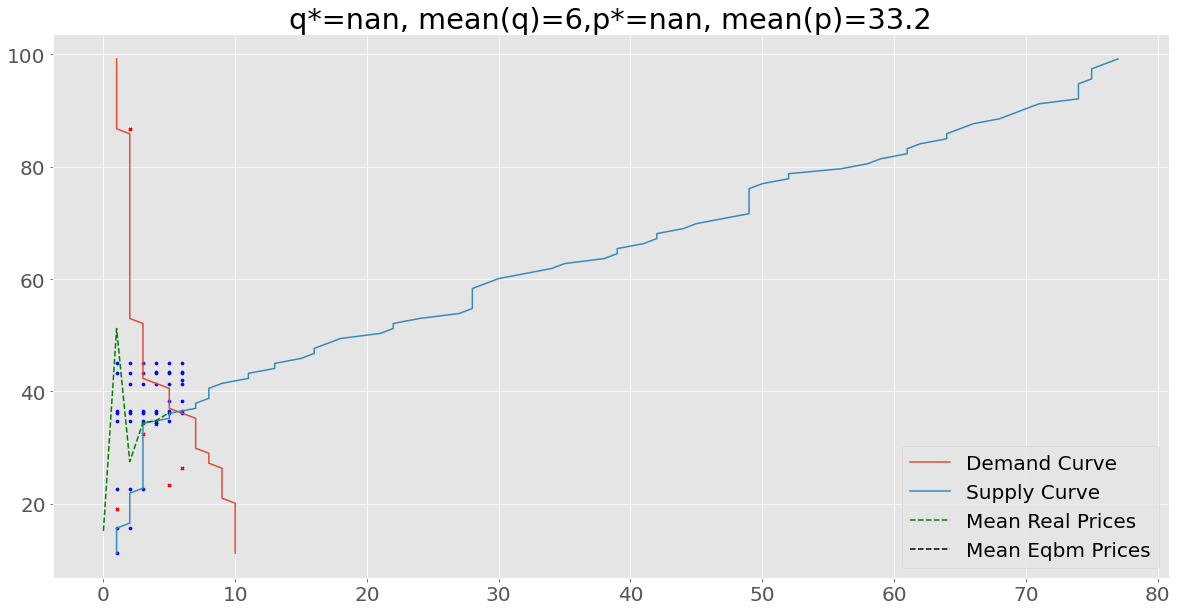

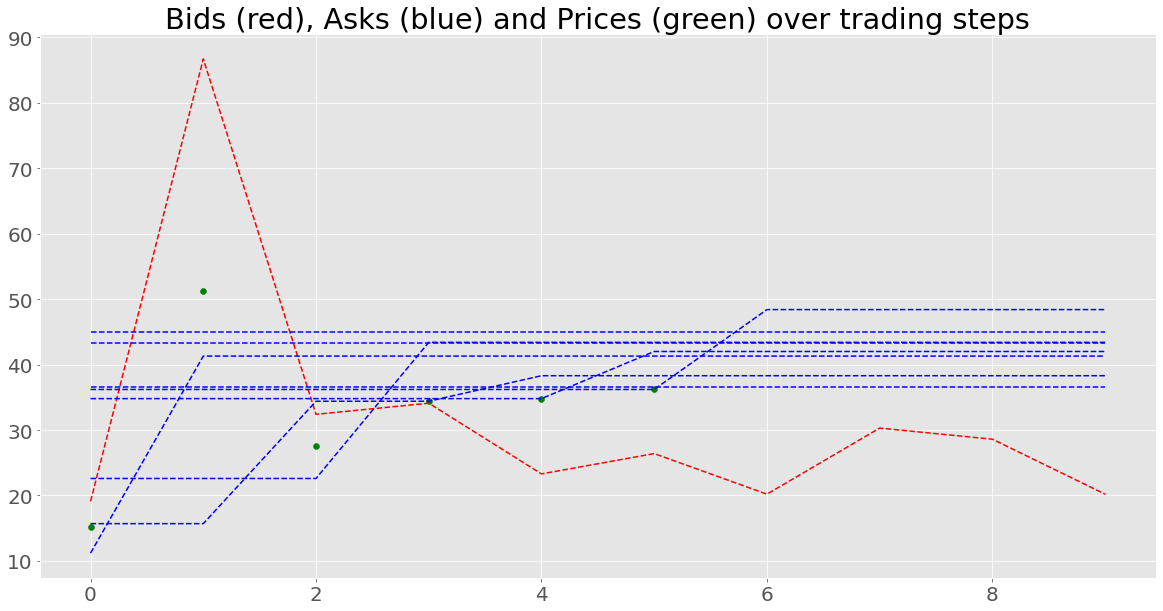

In [130]:
graph_period(db, 0, 0)

In [132]:
db.get_period(0, db.step_data.iloc[-1].period.item()).head(10)

,step,bids,asks,current_bid,current_bid_idx,current_ask,current_ask_idx,buy,sell,price,bprofit,sprofit
49990,0,[14.4],"[22.6, 43.3, 11.2, 15.7, 36.5, 45.0, 36.2, 34.8]",14.4,0,11.2,2,True,True,12.8,86.4,1.6
49991,1,[45.5],"[22.6, 43.3, 41.3, 15.7, 36.5, 45.0, 36.2, 34.8]",45.5,0,15.7,3,True,True,30.6,56.1,14.9
49992,2,[7.6],"[22.6, 43.3, 41.3, 34.4, 36.5, 45.0, 36.2, 34.8]",7.6,0,22.6,0,True,False,22.6,29.7,0.0
49993,3,[24.1],"[43.4, 43.3, 41.3, 34.4, 36.5, 45.0, 36.2, 34.8]",24.1,0,34.4,3,True,False,34.4,7.7,0.0
49994,4,[5.9],"[43.4, 43.3, 41.3, 38.3, 36.5, 45.0, 36.2, 34.8]",5.9,0,34.8,7,True,False,34.8,5.9,0.0
49995,5,[5.4],"[43.4, 43.3, 41.3, 38.3, 36.5, 45.0, 36.2, 42.0]",5.4,0,36.2,6,True,False,36.2,0.7,0.0
49996,6,[5.1],"[43.4, 43.3, 41.3, 38.3, 36.5, 45.0, 48.4, 42.0]",5.1,0,36.5,4,False,False,NaN,0.0,0.0
49997,7,[5.1],"[43.4, 43.3, 41.3, 38.3, 36.5, 45.0, 48.4, 42.0]",5.1,0,36.5,4,False,False,NaN,0.0,0.0
49998,8,[5.1],"[43.4, 43.3, 41.3, 38.3, 36.5, 45.0, 48.4, 42.0]",5.1,0,36.5,4,False,False,NaN,0.0,0.0
49999,9,[5.1],"[43.4, 43.3, 41.3, 38.3, 36.5, 45.0, 48.4, 42.0]",5.1,0,36.5,4,False,False,NaN,0.0,0.0


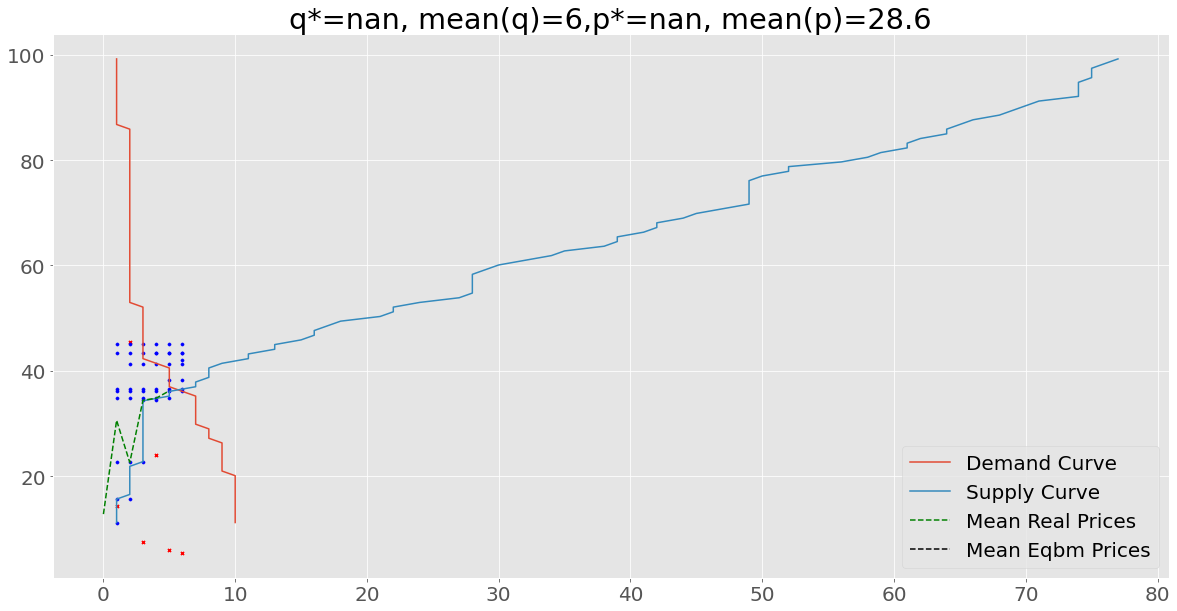

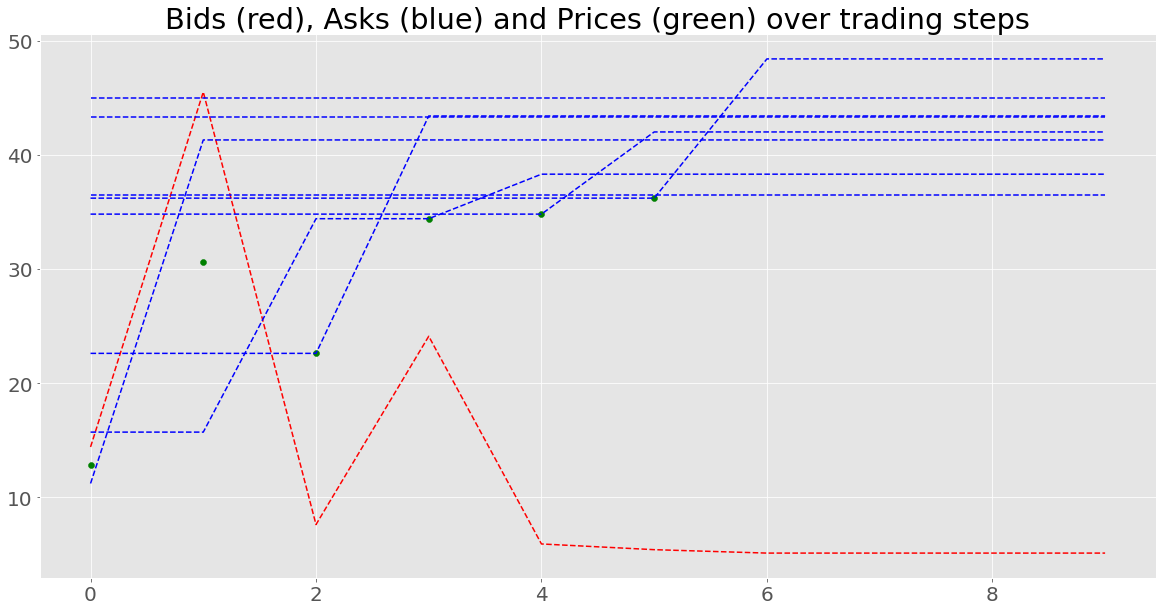

In [133]:
graph_period(db, 0, db.step_data.iloc[-1].period.item())

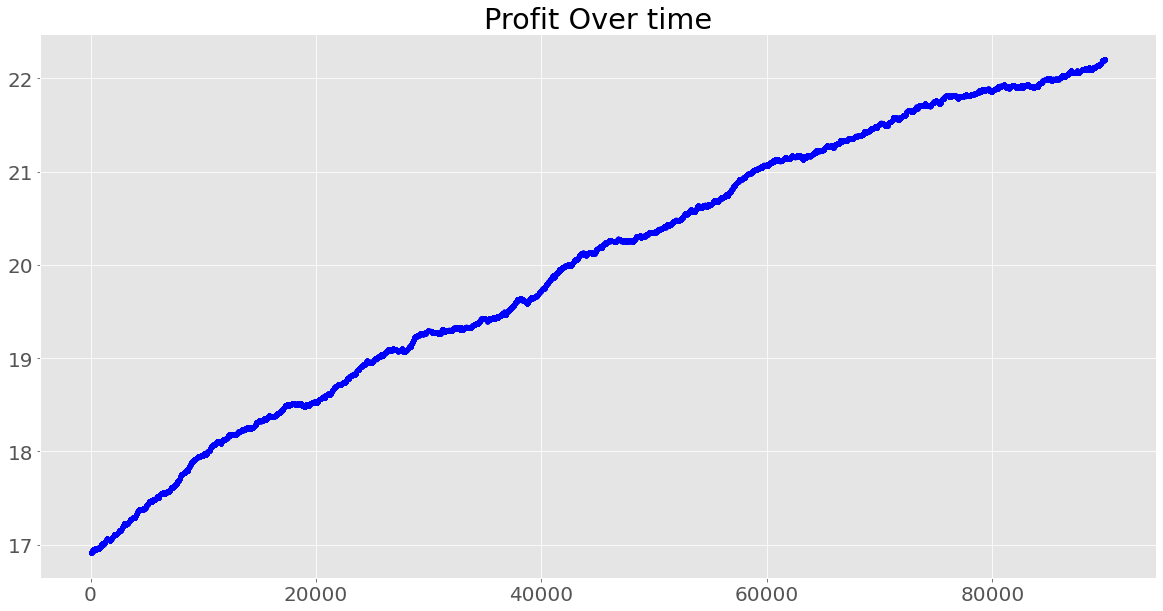

In [111]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams['font.size']=20
plt.plot(moving_average(np.array(db.buyers[0].profit_history),10000), label = 'Agent 1 Actions', marker = '.', c = 'b')
plt.title('Profit Over time') 
plt.show()

#### Test - against Honest

In [112]:
buyer_strategies = ['DQN', 'Honest']
seller_strategies = ['Honest','Honest','Honest','Honest','Honest','Honest','Honest','Honest']
nbuyers, nsellers = len(buyer_strategies), len(seller_strategies)
nrounds, nperiods, ntokens, nsteps, gametype, nbuyers, nsellers = 1, 10000, 10, 10, '1234', len(buyer_strategies), len(seller_strategies)
R1, R2, R3, R4 = gametype_to_ran(gametype)
game_metadata = [nrounds, nperiods, ntokens, nbuyers, nsellers, nsteps, R1, R2, R3, R4]
db = Database(game_metadata, buyer_strategies, seller_strategies)

for rnd in range(nrounds):
    db.reset_round()
    for period in range(nperiods):
        db.reset_period(rnd)
        for step in range(nsteps):
            bids = [buyer.bid(db) for buyer in db.buyers]
            asks = [seller.ask(db) for seller in db.sellers]
            current_ask, current_ask_idx, current_bid, current_bid_idx = current_bid_ask(bids, asks) 
            sale, price, bprofit, sprofit, buy, sell = buy_sell(db, current_bid, current_bid_idx, current_ask, current_ask_idx)
            step_data = [rnd,period,step,bids,asks,current_bid,current_bid_idx,current_ask,current_ask_idx,buy,sell,price,sale,bprofit,sprofit]
            db.add_step(step_data)
            [buyer.learn(db) for buyer in db.buyers]
            [seller.learn(db) for seller in db.sellers]

140.18202209472656 0.9801394849110637 15.413749999999999
145.09808349609375 0.9703868855675706 17.652499999999996
155.42166137695312 0.9607313266917007 17.34125
128.16558837890625 0.9511718427098701 16.138749999999998
134.1935577392578 0.9417074776561513 18.9275
151.28573608398438 0.9323372850766873 15.302499999999998
120.99617004394531 0.923060327935039 16.372499999999995
138.93931579589844 0.9138756785184889 16.86375
143.09487915039062 0.9047824183452553 15.333749999999998
136.89215087890625 0.8957796380726498 16.15
154.01239013671875 0.8868664374061404 16.93
132.56048583984375 0.8780419250093152 17.6425
149.5327911376953 0.8693052184147608 14.782499999999999
127.19094848632812 0.8606554439357967 17.35
143.34066772460938 0.8520917365791183 17.845
152.109130859375 0.8436132399582887 17.02875
159.63967895507812 0.8352191062081047 17.127499999999998
149.68553161621094 0.8269084958997996 17.432499999999997
146.03079223632812 0.8186805779571056 17.01625
140.87652587890625 0.81053452957314

KeyboardInterrupt: 

In [113]:
db.get_period(0, 0).head(10)

,step,bids,asks,current_bid,current_bid_idx,current_ask,current_ask_idx,buy,sell,price,bprofit,sprofit
0,0,"[77.4, 102.8]","[48.5, 16.5, 11.8, 18.5, 39.2, 17.4, 17.5, 36.8]",102.8,1,11.8,2,True,True,57.30,45.50,45.50
1,1,"[105.9, 90.5]","[48.5, 16.5, 26.3, 18.5, 39.2, 17.4, 17.5, 36.8]",105.9,0,16.5,1,True,True,61.20,40.60,44.70
2,2,"[96.1, 90.5]","[48.5, 37.9, 26.3, 18.5, 39.2, 17.4, 17.5, 36.8]",96.1,0,17.4,5,True,True,56.75,43.35,39.35
3,3,"[71.1, 90.5]","[48.5, 37.9, 26.3, 18.5, 39.2, 31.0, 17.5, 36.8]",90.5,1,17.5,6,True,True,54.00,36.50,36.50
4,4,"[126.3, 89.7]","[48.5, 37.9, 26.3, 18.5, 39.2, 31.0, 30.2, 36.8]",126.3,0,18.5,3,True,True,72.40,26.30,53.90
5,5,"[64.2, 89.7]","[48.5, 37.9, 26.3, 28.1, 39.2, 31.0, 30.2, 36.8]",89.7,1,26.3,2,True,True,58.00,31.70,31.70
6,6,"[117.1, 83.0]","[48.5, 37.9, 35.8, 28.1, 39.2, 31.0, 30.2, 36.8]",117.1,0,28.1,3,True,True,72.60,21.80,44.50
7,7,"[72.7, 83.0]","[48.5, 37.9, 35.8, 47.3, 39.2, 31.0, 30.2, 36.8]",83.0,1,30.2,6,True,True,56.60,26.40,26.40
8,8,"[103.9, 65.7]","[48.5, 37.9, 35.8, 47.3, 39.2, 31.0, 33.2, 36.8]",103.9,0,31.0,5,True,True,67.45,19.15,36.45
9,9,"[69.3, 65.7]","[48.5, 37.9, 35.8, 47.3, 39.2, 43.6, 33.2, 36.8]",69.3,0,33.2,6,True,True,51.25,35.35,18.05


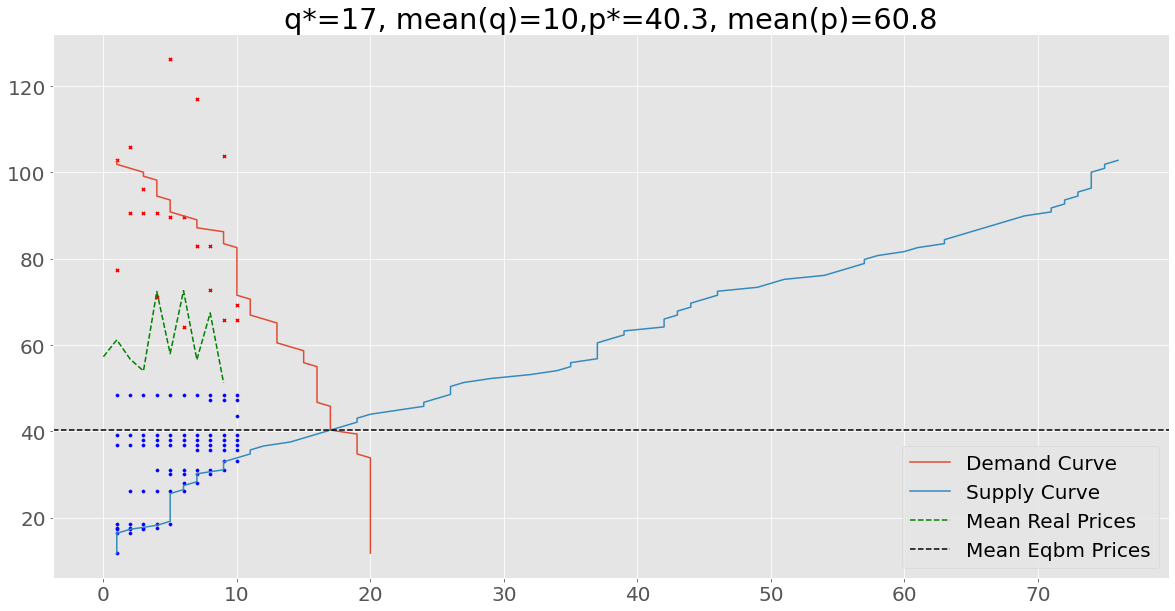

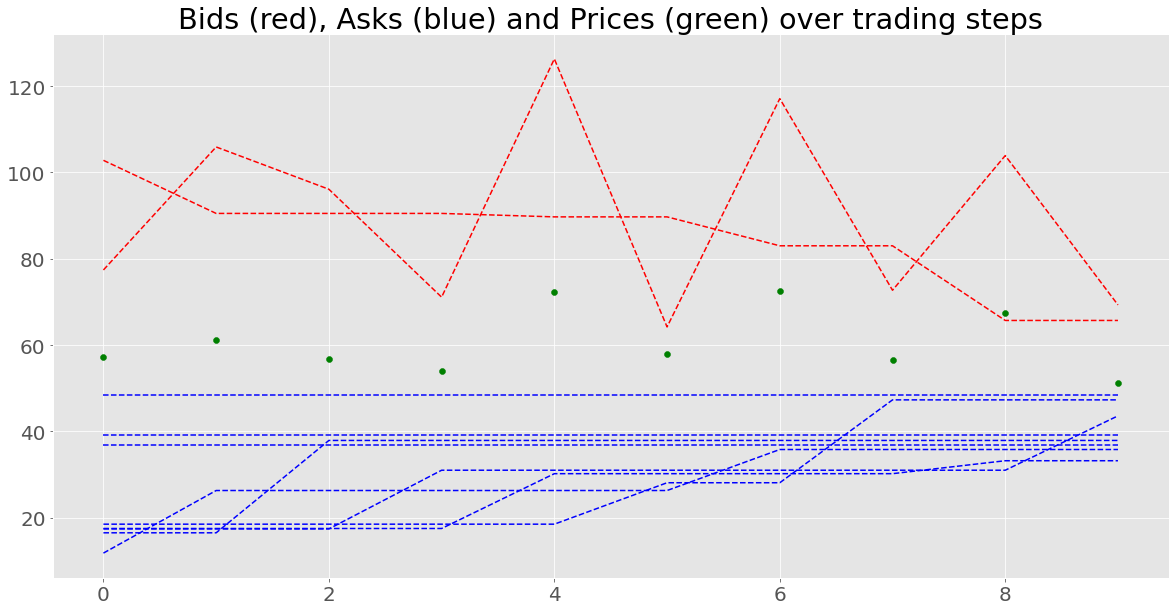

In [114]:
graph_period(db, 0, 0)

In [118]:
db.get_period(0, db.step_data.iloc[-1].period.item()-2).head(20)

,step,bids,asks,current_bid,current_bid_idx,current_ask,current_ask_idx,buy,sell,price,bprofit,sprofit
99540,0,"[105.9, 102.8]","[48.5, 16.5, 11.8, 18.5, 39.2, 17.4, 17.5, 36.8]",105.9,0,11.8,2,True,True,58.85,42.95,47.05
99541,1,"[104.1, 102.8]","[48.5, 16.5, 26.3, 18.5, 39.2, 17.4, 17.5, 36.8]",104.1,0,16.5,1,True,True,60.30,39.80,43.80
99542,2,"[67.1, 102.8]","[48.5, 37.9, 26.3, 18.5, 39.2, 17.4, 17.5, 36.8]",102.8,1,17.4,5,True,True,60.10,42.70,42.70
99543,3,"[102.6, 90.5]","[48.5, 37.9, 26.3, 18.5, 39.2, 31.0, 17.5, 36.8]",102.6,0,17.5,6,True,True,60.05,38.65,42.55
99544,4,"[71.7, 90.5]","[48.5, 37.9, 26.3, 18.5, 39.2, 31.0, 30.2, 36.8]",90.5,1,18.5,3,True,True,54.50,36.00,36.00
99545,5,"[105.7, 89.7]","[48.5, 37.9, 26.3, 28.1, 39.2, 31.0, 30.2, 36.8]",105.7,0,26.3,2,True,True,66.00,28.40,39.70
99546,6,"[72.7, 89.7]","[48.5, 37.9, 35.8, 28.1, 39.2, 31.0, 30.2, 36.8]",89.7,1,28.1,3,True,True,58.90,30.80,30.80
99547,7,"[107.4, 83.0]","[48.5, 37.9, 35.8, 47.3, 39.2, 31.0, 30.2, 36.8]",107.4,0,30.2,6,True,True,68.80,17.80,38.60
99548,8,"[90.1, 83.0]","[48.5, 37.9, 35.8, 47.3, 39.2, 31.0, 33.2, 36.8]",90.1,0,31.0,5,True,True,60.55,26.05,29.55
99549,9,"[73.6, 83.0]","[48.5, 37.9, 35.8, 47.3, 39.2, 43.6, 33.2, 36.8]",83.0,1,33.2,6,True,True,58.10,24.90,24.90


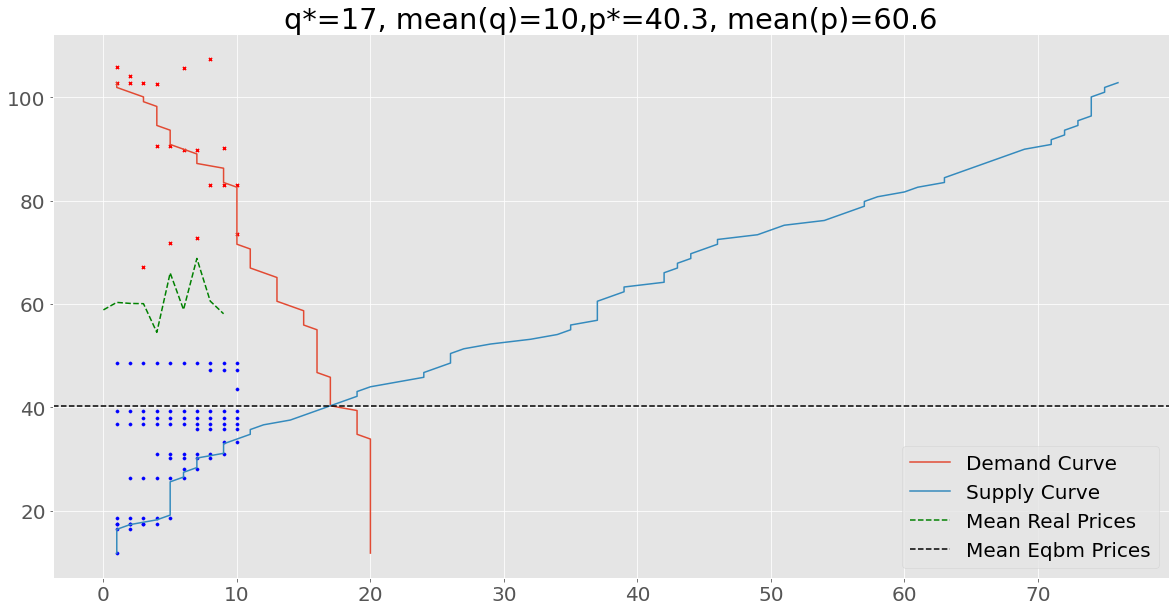

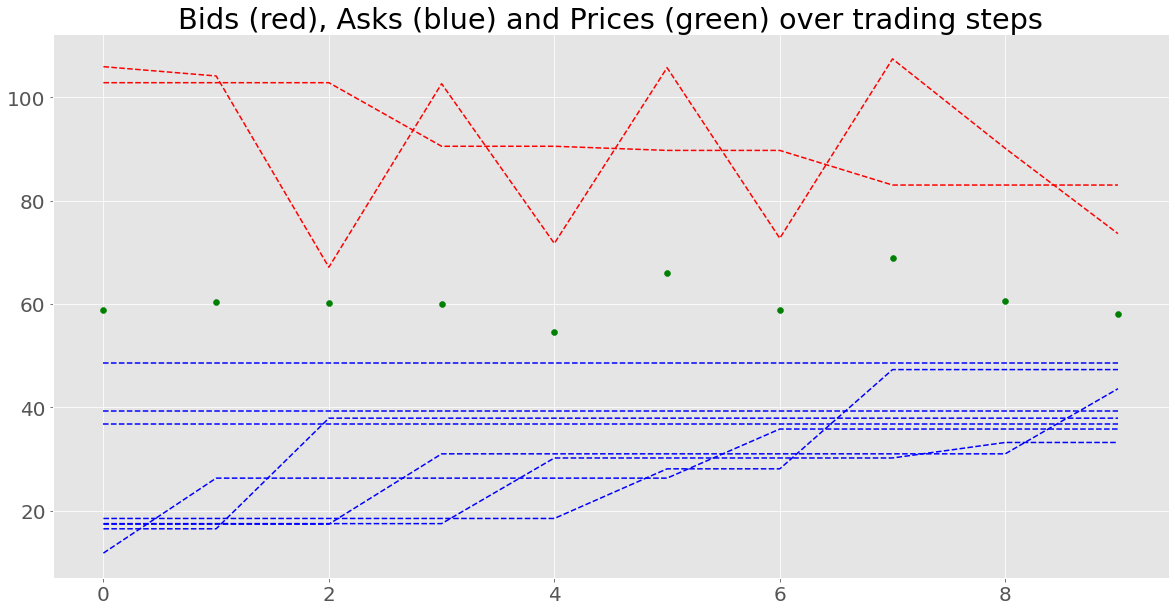

In [116]:
graph_period(db, 0, db.step_data.iloc[-1].period.item()-2)

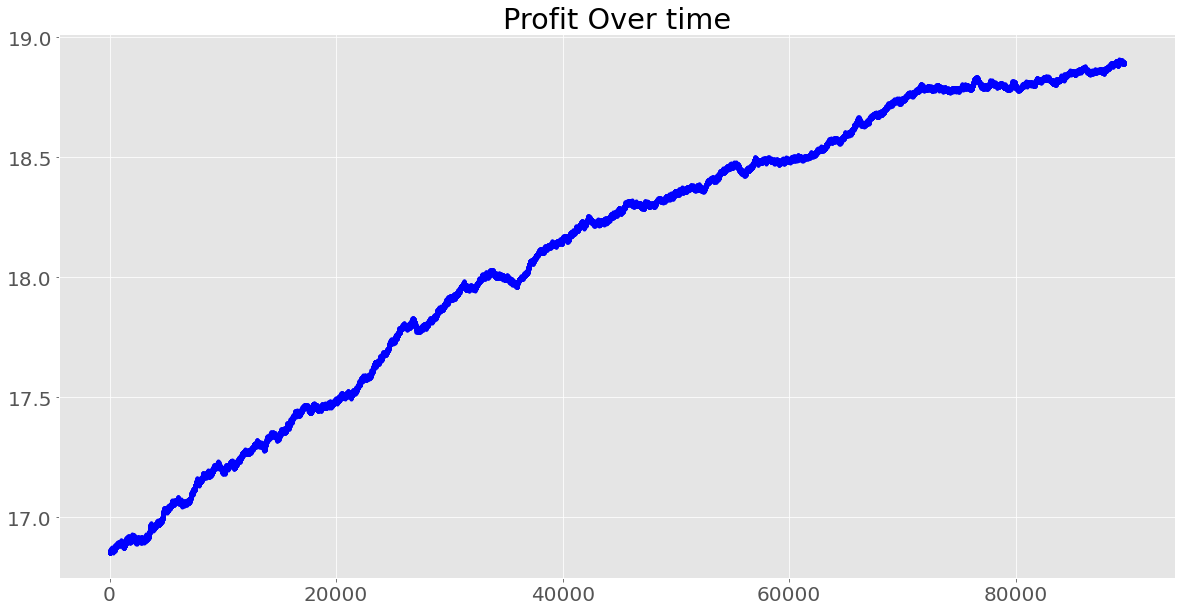

In [117]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams['font.size']=20
plt.plot(moving_average(np.array(db.buyers[0].profit_history),10000), label = 'Agent 1 Actions', marker = '.', c = 'b')
plt.title('Profit Over time') 
plt.show()

In [ ]:
buyer_strategies = ['DQN', 'Honest']
seller_strategies = ['Honest','Honest','Honest','Honest','Honest','Honest','Honest','Honest']
nbuyers, nsellers = len(buyer_strategies), len(seller_strategies)
nrounds, nperiods, ntokens, nsteps, gametype, nbuyers, nsellers = 1, 10000, 10, 10, '1234', len(buyer_strategies), len(seller_strategies)
R1, R2, R3, R4 = gametype_to_ran(gametype)
game_metadata = [nrounds, nperiods, ntokens, nbuyers, nsellers, nsteps, R1, R2, R3, R4]
db = Database(game_metadata, buyer_strategies, seller_strategies)

for rnd in range(nrounds):
    db.reset_round()
    for period in range(nperiods):
        db.reset_period(rnd)
        for step in range(nsteps):
            bids = [buyer.bid(db) for buyer in db.buyers]
            asks = [seller.ask(db) for seller in db.sellers]
            current_ask, current_ask_idx, current_bid, current_bid_idx = current_bid_ask(bids, asks) 
            sale, price, bprofit, sprofit, buy, sell = buy_sell(db, current_bid, current_bid_idx, current_ask, current_ask_idx)
            step_data = [rnd,period,step,bids,asks,current_bid,current_bid_idx,current_ask,current_ask_idx,buy,sell,price,sale,bprofit,sprofit]
            db.add_step(step_data)
            [buyer.learn(db) for buyer in db.buyers]
            [seller.learn(db) for seller in db.sellers]

In [16]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class TradingEnv(gym.Env):
    def __init__(self, token_values, other_buyers, seller_strategies):
        buyer_strategies = ['Honest'] + other_buyers
        seller_strategies = ['Honest','Honest','Honest','Honest','Honest','Honest','Honest','Honest']
        nbuyers, nsellers = len(buyer_strategies), len(seller_strategies)
        nrounds, nperiods, ntokens, nsteps, gametype, nbuyers, nsellers = 1, 1, 10, 10, '1234', len(buyer_strategies), len(seller_strategies)

        pass

    def reset(self):
        # Reset the environment to its initial state
        pass

    def step(self, action):
        # Take a step in the environment given an action
        pass

    def close(self):
        # Clean up resources (optional)
        pass